# DeblurGAN

In [0]:
!pip install easycolab
import easycolab as ec
ec.mount()

  Created wheel for easycolab: filename=easycolab-0.1b29-cp36-none-any.whl size=4472 sha256=4b4b64febf49b016ccc7f5c4008be96a733b54867b297c667a4f3714437ee9fb
  Stored in directory: /root/.cache/pip/wheels/1b/c3/03/9d9371c4d3a117eff9caf88148e2f18ddf556543b4475055f1
Successfully built easycolab
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Opening directory /content/gdrive/My Drive/
Done!


In [0]:
import torch
from torch import nn
import torch.utils.data as torch_data
from torchvision import transforms
from torchvision import models
import torchvision
from tqdm import tqdm
import numpy as np
import os
import random
import PIL
import matplotlib.pyplot as plt

## Create train/test sets

In [0]:
class create_set(torch_data.Dataset):
    def __init__(self, path_X, path_y,transform=None):
        super(create_set, self).__init__()
        #self.X=[str(i+1)+'.png' for i in range(len(os.listdir(path_X)))][6:]
        #self.y=[str(i+1)+'.png' for i in range(len(os.listdir(path_y)))][6:]
        
        self.X=sorted(os.listdir(path_X))[6:]
        self.y=sorted(os.listdir(path_y))[6:]
        self.transform=transform
        self.path_X=path_X
        self.path_y=path_y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X=PIL.Image.open(os.path.join(self.path_X,self.X[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        y=PIL.Image.open(os.path.join(self.path_y,self.y[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        if self.transform is not None:
            rand=np.random.randint(10**9)
            random.seed(rand)
            X=self.transform(X)
            random.seed(rand)
            y=self.transform(y)
        return X, y

In [0]:
train_set=create_set('./bia_proj/data/trainX/', './bia_proj/data/trainY/', transform=transforms.Compose([
        transforms.ToTensor()
        ]))

In [0]:
class create_set(torch_data.Dataset):
    def __init__(self, path_X, path_y,transform=None):
        super(create_set, self).__init__()
        #self.X=[str(i+1)+'.png' for i in range(len(os.listdir(path_X)))][5:6]
        #self.y=[str(i+1)+'.png' for i in range(len(os.listdir(path_y)))][5:6]        
        self.X=sorted(os.listdir(path_X))[5:6]
        self.y=sorted(os.listdir(path_y))[5:6]
        self.transform=transform
        self.path_X=path_X
        self.path_y=path_y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X=PIL.Image.open(os.path.join(self.path_X,self.X[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        y=PIL.Image.open(os.path.join(self.path_y,self.y[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        if self.transform is not None:
            rand=np.random.randint(10**9)
            random.seed(rand)
            X=self.transform(X)
            random.seed(rand)
            y=self.transform(y)
        return X, y

In [0]:
test_set=create_set('./bia_proj/data/trainX/', './bia_proj/data/trainY/', 
                    transform=transforms.Compose([transforms.ToTensor()]))

In [0]:
train_loader = torch_data.DataLoader(train_set, batch_size=1, shuffle=True) 


In [0]:
test_loader = torch_data.DataLoader(test_set, batch_size=1, shuffle=False)

## Create model

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.contiguous().view(input.shape[0], -1)

class ResBlock(nn.Module):
  def __init__(self):
    super(ResBlock, self).__init__()
    self.padding1=nn.ReflectionPad2d(1)
    self.conv1=nn.Conv2d(256, 256, kernel_size=3)
    self.conv1.weight.data.normal_(0.0, 0.02)
    self.norm1=nn.InstanceNorm2d(256)
    self.sequential=nn.Sequential(self.padding1,
                                  self.conv1,
                                  self.norm1,
                                  nn.ReLU(True),
                                  nn.Dropout(0.5))
  def forward(self, x):
    y=self.sequential(x)
    x=x+y
    return x


class Generator_(nn.Module):
  def __init__(self):
    super(Generator_, self).__init__()
    self.padding1=nn.ReflectionPad2d(3)
    self.conv1=nn.Conv2d(3, 64, kernel_size=7)
    self.conv1.weight.data.normal_(0.0, 0.02)
    self.norm1=nn.InstanceNorm2d(64)
    self.relu1=nn.ReLU(True)

    self.conv2=nn.Conv2d(64, 128, kernel_size=3, stride=2,padding=1)
    self.conv2.weight.data.normal_(0.0, 0.02)
    self.norm2=nn.InstanceNorm2d(128)
    self.relu2=nn.ReLU(True)


    self.conv3=nn.Conv2d(128, 256, kernel_size=3,stride=2, padding=1)
    self.conv3.weight.data.normal_(0.0, 0.02)
    self.norm3=nn.InstanceNorm2d(256)
    self.relu3=nn.ReLU(True)

    self.resblocks=nn.Sequential(ResBlock(),
                                  ResBlock(),
                                  ResBlock(),
                                  ResBlock(),
                                  ResBlock(),
                                  ResBlock(),
                                  ResBlock(),
                                  ResBlock(),
                                  ResBlock())

    self.convt4=nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.convt4.weight.data.normal_(0.0, 0.02)
    self.norm4=nn.InstanceNorm2d(128)
    self.relu4=nn.ReLU(True)

    self.convt5=nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.convt5.weight.data.normal_(0.0, 0.02)
    self.norm5=nn.InstanceNorm2d(64)
    self.relu5=nn.ReLU(True)

    self.padding6=nn.ReflectionPad2d(3)
    self.conv6=nn.Conv2d(64, 3, kernel_size=7)
    self.conv6.weight.data.normal_(0.0, 0.02)
    self.tanh=nn.Tanh()
    self.sequential=nn.Sequential(self.padding1,
                                  self.conv1,
                                  self.norm1,
                                  self.relu1,
                                  self.conv2,
                                  self.norm2,
                                  self.relu2,
                                  self.conv3,
                                  self.norm3,
                                  self.relu3,
                                  self.resblocks,
    
                                  self.convt4,
                                  self.norm4,
                                  self.relu4,
                              
                                  self.convt5,
                                  self.norm5,
                                  self.relu5,
                                  
                                  self.padding6,
                                  self.conv6,
                                  self.tanh)
                              

  def forward(self, x):
    y=self.sequential(x)
    x=x+y
    x=torch.clamp(x, min=-1, max=1)
    return x



class Discriminator_(nn.Module):
  def __init__(self):
    super(Discriminator_, self).__init__()
    self.conv1=nn.Conv2d(3, 64, kernel_size=4, stride=2)
    self.conv1.weight.data.normal_(0.0, 0.02)
    self.lrelu1=nn.LeakyReLU(0.2,True)

    self.conv2=nn.Conv2d(64, 128, kernel_size=4, stride=2)
    self.conv2.weight.data.normal_(0.0, 0.02)
    self.norm2=nn.InstanceNorm2d(128)
    self.lrelu2=nn.LeakyReLU(0.2,True)

    self.conv3=nn.Conv2d(128, 256, kernel_size=4, stride=2)
    self.conv3.weight.data.normal_(0.0, 0.02)
    self.norm3=nn.InstanceNorm2d(256)
    self.lrelu3=nn.LeakyReLU(0.2,True)

    self.conv4=nn.Conv2d(256, 512, kernel_size=4, stride=2)
    self.conv4.weight.data.normal_(0.0, 0.02)
    self.norm4=nn.InstanceNorm2d(512)
    self.lrelu4=nn.LeakyReLU(0.2,True)

    self.conv5=nn.Conv2d(512, 512, kernel_size=4)
    self.conv5.weight.data.normal_(0.0, 0.02)
    self.norm5=nn.InstanceNorm2d(512)
    self.lrelu5=nn.LeakyReLU(0.2,True)

    self.conv6=nn.Conv2d(512, 1, kernel_size=4)
    self.conv6.weight.data.normal_(0.0, 0.02)
    self.fc1=nn.Linear(64,1024)
    self.fc2=nn.Linear(1024,1)

    self.sequential=nn.Sequential(self.conv1,
                                  self.lrelu1,

                                  self.conv2,
                                  self.norm2,
                                  self.lrelu2,

                                  self.conv3,
                                  self.norm3,
                                  self.lrelu3,

                                  self.conv4,
                                  self.norm4,
                                  self.lrelu4,

                                  self.conv5,
                                  self.lrelu5,

                                  self.conv6,

                                  Flatten(),
                                  self.fc1,
                                  nn.Tanh(),                          
                                  self.fc2,
                                  nn.Sigmoid(),
                                  )

  def forward(self, x):
    x=self.sequential(x)
    return x



In [0]:
discriminator=Discriminator_().to('cuda:0')
generator=Generator_().to('cuda:0')
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
dis_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [0]:
def contentFunc():
		conv_3_3_layer = 14
		cnn=models.vgg19(pretrained=True).features
		cnn=cnn.to('cuda:0')
		model=nn.Sequential()
		model=model.to('cuda:0')
		for i,layer in enumerate(list(cnn)):
			model.add_module(str(i),layer)
			if i == conv_3_3_layer:
				break
		return model

def discriminator_loss(discriminator,x_real, x_fake):
    real_preds = discriminator(x_real)
    fake_preds = discriminator(x_fake)
    
    L_gp=calc_gradient_penalty(discriminator,x_real.data, x_fake.data)
    loss_D = -torch.mean(real_preds) + torch.mean(fake_preds)+L_gp
    return loss_D

def generator_loss(fake_preds):
    return -torch.mean(fake_preds)

def content_loss(x_real,x_fake):
    criterion = nn.MSELoss()
    model=contentFunc()
    model.eval()
    fake_preds=model.forward(x_fake)
    real_preds=model.forward(x_real)
    loss = criterion(real_preds.detach(),fake_preds)
    return loss

def calc_gradient_penalty(discriminator,x_real, x_fake):
    eps=torch.Tensor(np.random.random((x_real.size(0), 1, 1, 1))).cuda()
    eps=(eps*x_real.cuda()+(1-eps)*x_fake.cuda()).requires_grad_(True)
    x_hat=discriminator(eps)
    grad_output=Variable(torch.Tensor(x_real.shape[0], 1).fill_(1.0), requires_grad=False)
    grad=torch.autograd.grad(outputs=x_hat, inputs=eps, grad_outputs=grad_output.cuda(), create_graph=True, only_inputs=True, retain_graph=True)[0]
    grad=grad.reshape(grad.size(0), -1)
    L_gp=10*((grad.norm(2, dim=1)-1)**2).mean()
    return L_gp

In [0]:
def train_dis(discriminator, generator,x_real, x_fake):
    dis_opt.zero_grad()
    loss_D = discriminator_loss(discriminator,x_real, x_fake)
    loss_D.backward(retain_graph=True)
    dis_opt.step()
    return loss_D.item()

def train_gen(discriminator, generator,x_real,x_fake):
    gen_opt.zero_grad()
    fake_preds=discriminator(x_fake)
    loss_G = generator_loss(fake_preds)
    loss_cont=content_loss(x_real,x_fake)
    loss_G=loss_G+loss_cont*100.
    loss_G.backward()
    gen_opt.step()
    return loss_G.item()

## Training model

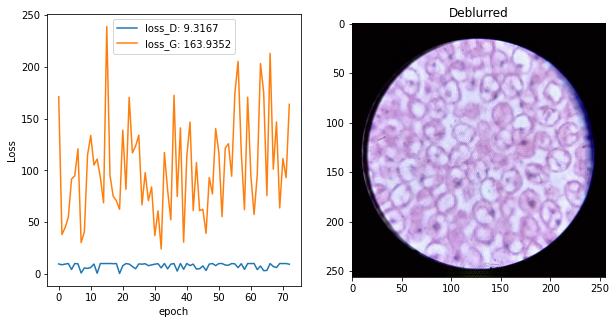

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
losses_D_hist = []
losses_G_hist = []
for epoch in range(1, 200):
    generator.train(True)
    discriminator.train(True)
    for z,x in train_loader:
        z=z.to('cuda:0')
        x=x.to('cuda:0')
        z=Variable(z)
        x_fake=generator(z)
        x_real=Variable(x)
        for _ in range(1):
            loss_D = train_dis(discriminator, generator, x_real, x_fake)
        loss_G = train_gen(discriminator, generator, x_real,x_fake)
    losses_D_hist.append(loss_D)
    losses_G_hist.append(loss_G)
    clear_output(True)
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
      z=test_set[0][0]
      z=z.to('cuda:0').unsqueeze(0)
      z=Variable(z)
      img=generator(z)
      img=torch.clamp(img, min=0, max=1)
      plt.figure(figsize=(10,5))
      plt.subplot(1,2,1)
      plt.ylabel('Loss')
      plt.xlabel('epoch')
      plt.plot(losses_D_hist, label='loss_D: {:.4f}'.format(losses_D_hist[-1]))
      plt.plot(losses_G_hist, label='loss_G: {:.4f}'.format(losses_G_hist[-1]))
      plt.legend()
      plt.subplot(1,2,2)
      plt.title("Deblurred")
      plt.imshow(img.cpu().detach().numpy().transpose([0, 2, 3, 1])[0])    
      plt.show()  
    torch.save(generator.state_dict(), './bia_proj/generator.pth')
    torch.save(discriminator.state_dict(), './bia_proj/discriminator.pth')

In [0]:
generator.eval()
discriminator.eval()
torch.save(generator.state_dict(), './bia_proj/generator.pth')
torch.save(discriminator.state_dict(), './bia_proj/discriminator.pth')

In [0]:

discriminator=Discriminator_().to('cuda:0')
generator=Generator_().to('cuda:0')
generator.load_state_dict(torch.load('./bia_proj/generator.pth'))
discriminator.load_state_dict(torch.load('./bia_proj/discriminator.pth'))
generator.eval()
discriminator.eval()


Discriminator_(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
  (lrelu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (norm2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (lrelu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
  (norm3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (lrelu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
  (norm4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (lrelu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
  (norm5): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (lrelu5): LeakyReLU(negative_slope=0.2, inplace=True)
  (co

## Evalualion on the picture from train:

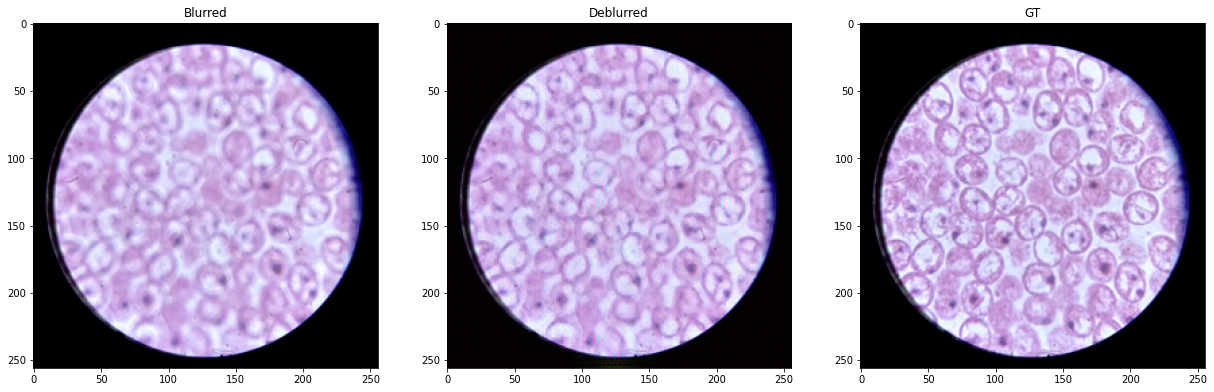

In [0]:
with torch.no_grad():
  z=test_set[0][0]
  z=z.to('cuda:0').unsqueeze(0)
  z=Variable(z)
  img=generator(z)
  img=torch.clamp(img, min=0, max=1)
  plt.figure(figsize=(21,7))
  plt.subplot(1,3,1)
  plt.title("Blurred")
  plt.imshow(test_set[0][0].numpy().transpose([1, 2, 0]))
  plt.subplot(1,3,2)
  plt.title("Deblurred")
  plt.imshow(img.cpu().detach().numpy().transpose([0, 2, 3, 1])[0], )
  plt.subplot(1,3,3)

  plt.title("GT")
  plt.imshow(test_set[0][1].numpy().transpose([1, 2, 0]))
  
